# Diffusion Transformer (DiT) with Sliding Window Attention (SWA) vs. Full Attention

## Introduction

This notebook focuses on Task 2b and Task 3 of the comprehensive DiT study. The primary goal is to implement, train, and evaluate a Diffusion Transformer (DiT) model incorporating **Sliding Window Attention (SWA)**. We will compare its performance against a baseline DiT model using the standard **Full (Global) Attention** mechanism. Both models will be trained from scratch on a landscape image dataset without class conditioning.

## Background & Motivation

Standard self-attention in Transformers has a computational and memory complexity quadratic in the sequence length ($O(N^2)$). For high-resolution images, the sequence length (number of patches) can become very large, making full attention computationally expensive.

**Sliding Window Attention (SWA)** is an approximation technique designed to reduce this complexity. Instead of attending to all other tokens in the sequence, each token only attends to a small, local window of neighboring tokens. This reduces the complexity to roughly $O(N \cdot k)$, where $k$ is the window size ($k \ll N$).

The key question is: *Can SWA provide significant computational benefits during training and inference while maintaining acceptable generative quality compared to full attention for image generation tasks?*

## Methodology

1.  **SWA Implementation:**
    *   Define a custom `SlidingWindowAttention` PyTorch module that performs attention only within defined local windows (e.g., 3x3 patch window).
    *   Implement a helper function (`replace_attention_with_swa`) to swap the standard attention blocks in a DiT model with our custom SWA blocks.

2.  **Dataset:**
    *   Utilize the "Landscape Pictures" dataset available on Kaggle (`arnaud58/landscape-pictures`). Downloaded via `kagglehub`.
    *   Images are resized to 256x256 and normalized.
    *   Training is performed **unconditionally** (no class labels are used).

3.  **Models:**
    *   **Base Architecture:** DiT-B/4 (Diffusion Transformer - Base size, patch size 4).
    *   **VAE:** A pre-trained Variational Autoencoder (`stabilityai/sd-vae-ft-ema`) is used to encode images into a lower-dimensional latent space (32x32 for 256x256 images) and decode latents back into images. The DiT models operate entirely within this latent space. Latents are scaled by `0.18215` as is standard practice.
    *   **Two Models Trained:**
        *   `model_full`: Standard DiT-B/4 with full self-attention.
        *   `model_swa`: DiT-B/4 where attention blocks are replaced with `SlidingWindowAttention`.

4.  **Diffusion Setup:**
    *   Standard DDPM noise schedule (linear beta schedule from `1e-4` to `0.02` over `T=1000` steps).
    *   The `diffusion.py` utilities from the original DiT repository are used for noise scheduling and sampling loops.

5.  **Training:**
    *   Both `model_full` and `model_swa` are trained from scratch using the same hyperparameters:
        *   Optimizer: Adam
        *   Learning Rate: `1e-4`
        *   Batch Size: 4
        *   Number of Epochs: 100
        *   Loss Function: Mean Squared Error (MSE) between the predicted noise and the actual noise added.
    *   Training uses Automatic Mixed Precision (`torch.amp`) for efficiency.

6.  **Sampling:**
    *   After training (or loading pre-trained weights), generate sample images from both `model_full` and `model_swa` using the DDPM `p_sample_loop`.
    *   These samples (`sample_full.png`, `sample_swa.png`) are used for visual comparison.

7.  **Evaluation:**
    *   **Metrics:**
        *   **Fréchet Inception Distance (FID):** Calculated using `torch-fidelity` between generated samples and real samples from the dataset. Measures perceptual similarity based on Inception-v3 features. Lower is better.
        *   **CLIP Mean Maximum Discrepancy (CMMD):** Implemented to compare the distribution of generated vs. real images in the embedding space of vision-language models. Lower is better.
            *   Calculated using embeddings from:
                *   CLIP (`openai/clip-vit-base-patch32`)
                *   SigLIP (`google/siglip-base-patch16-224`)
                *   ALIGN (`kakaobrain/align-base`)
    *   **Process:** The `evaluate_models` function orchestrates sample generation, loading real images, calculating FID, and calculating CMMD for all specified embedding models, incorporating memory optimization techniques (batching, CPU transfers, cache clearing).
    *   **Results:** Quantitative scores are saved to `evaluation_results.json` and visualized.

## Expected Outcome

We expect SWA to potentially reduce training/inference time and memory usage compared to full attention. However, we anticipate a possible trade-off in generative quality, as SWA's limited receptive field might struggle to capture long-range dependencies crucial for coherent landscape generation. The FID and CMMD scores will quantify this difference, while visual inspection provides qualitative insights. The comparison across different CMMD embedding models (CLIP, SigLIP, ALIGN) will test the robustness of the evaluation.

## Dependencies & Setup

*   **Core Libraries:** `torch`, `torchvision`, `diffusers`, `transformers`, `matplotlib`, `plotly`, `pandas`, `kagglehub`, `xformers` (optional but recommended for efficiency), `pytorch-fid`, `torch-fidelity`.
*   **Hardware:** A CUDA-enabled GPU is required for training and efficient inference.
*   **Kaggle:** Ensure you have logged in via `kagglehub.login()` to download the dataset.

## Notebook Structure

The following cells implement the steps outlined above:
1.  Imports and Kaggle Setup.
2.  Cloning DiT repository and installing dependencies (if needed).
3.  Definition of the `SlidingWindowAttention` module.
4.  Dataset loading (`SingleClassImageDataset`).
5.  Model and VAE initialization.
6.  Training loop implementation (`train_model_latent`).
7.  Training execution for both `model_full` and `model_swa`.
8.  Loading trained models (or pre-trained checkpoints).
9.  Sample generation code and execution.
10. Evaluation function definitions (FID, CMMD, MMD, embedding helpers).
11. Evaluation execution (`evaluate_models`).
12. Results visualization.

---

In [1]:

!git clone https://github.com/facebookresearch/DiT.git
%cd DiT


!pip install -q xformers plotly torchvision pytorch-fid


Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 102 (delta 57), reused 33 (delta 33), pack-reused 20 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 38.56 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/kaggle/working/DiT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 42.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━

In [2]:
import os, time, copy, math
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils as vutils
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# --- Define a simplified Sliding Window Attention (SWA) module ---
class SlidingWindowAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, window_size=3, dropout=0.0, use_relative_pe=True):
        super().__init__()
        self.num_heads = num_heads
        self.window_size = window_size
        self.head_dim = hidden_size // num_heads
        self.scale = self.head_dim ** -0.5
        self.hidden_size = hidden_size
        self.use_relative_pe = use_relative_pe
        
        # QKV projection
        self.qkv = nn.Linear(hidden_size, hidden_size * 3, bias=True)
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        
        #optional addition i have made
        if use_relative_pe:
            self.rel_pos_bias = nn.Parameter(
                torch.zeros(2 * window_size - 1, num_heads)
            )
            nn.init.trunc_normal_(self.rel_pos_bias, std=0.02)
    
    def _get_rel_pos_bias(self, window_size):
        """Get relative positional bias for a window"""
        rel_pos_bias = self.rel_pos_bias
        # Convert to attention bias format
        L = window_size
        rel_pos = torch.arange(0, L, dtype=torch.long, device=rel_pos_bias.device)
        rel_pos_mat = rel_pos[:, None] - rel_pos[None, :]
        rel_pos_mat = rel_pos_mat + self.window_size - 1  # Shift to [0, 2*window_size-2]
        return rel_pos_bias[rel_pos_mat]  # [window_size, window_size, num_heads]
    
    def _extract_windows(self, x, window_size):
        """Extract sliding windows from the input sequence"""
        B, N, C = x.shape
        # Pad the sequence to ensure we can create windows for all positions
        padding = window_size // 2
        x_padded = F.pad(x, (0, 0, padding, padding), value=0)
        
        # Initialize output tensor
        windows = []
        
        # Extract windows by sliding through the sequence
        for i in range(N):
            # Extract window centered at position i
            window = x_padded[:, i:i+window_size, :]
            windows.append(window)
            
        # Stack windows along a new dimension
        return torch.stack(windows, dim=1)  # [B, N, window_size, C]
    
    def forward(self, x):
        """
        x: (B, N, C) where N is the sequence length
        Returns: (B, N, C)
        """
        B, N, C = x.shape
        
        # Project to Q, K, V
        qkv = self.qkv(x)  # (B, N, 3 * C)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Extract windows for keys and values
        # We use the actual sliding window approach instead of the reshaping approach
        # that would be used for non-overlapping windows
        k_windows = self._extract_windows(
            k.transpose(1, 2).reshape(B, N, C), self.window_size
        ).reshape(B, N, self.window_size, self.num_heads, self.head_dim)
        
        v_windows = self._extract_windows(
            v.transpose(1, 2).reshape(B, N, C), self.window_size
        ).reshape(B, N, self.window_size, self.num_heads, self.head_dim)
        
        # Reshape for batch matrix multiplication
        q = q.unsqueeze(3)  # [B, num_heads, N, 1, head_dim]
        k_windows = k_windows.permute(0, 3, 1, 2, 4)  # [B, num_heads, N, window_size, head_dim]
        v_windows = v_windows.permute(0, 3, 1, 2, 4)  # [B, num_heads, N, window_size, head_dim]
        
        # Compute attention scores
        attn_scores = torch.matmul(q, k_windows.transpose(-2, -1)) * self.scale  # [B, num_heads, N, 1, window_size]
        
        # Add relative positional encoding if specified
        if self.use_relative_pe:
            rel_pos_bias = self._get_rel_pos_bias(self.window_size)  # [window_size, window_size, num_heads]
            rel_pos_bias = rel_pos_bias.permute(2, 0, 1)  # [num_heads, window_size, window_size]
            rel_pos_bias = rel_pos_bias.unsqueeze(0).unsqueeze(2)  # [1, num_heads, 1, window_size, window_size]
            # We only need the last row of the rel_pos_bias for each query
            rel_pos_bias = rel_pos_bias[:, :, :, -1:, :]  # [1, num_heads, 1, 1, window_size]
            attn_scores = attn_scores + rel_pos_bias
        
        # Apply softmax to get attention weights
        attn = torch.softmax(attn_scores, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention weights to values
        out = torch.matmul(attn, v_windows)  # [B, num_heads, N, 1, head_dim]
        out = out.squeeze(3)  # [B, num_heads, N, head_dim]
        
        # Reshape back to original dimensions
        out = out.transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        out = self.out_proj(out)
        
        return out

# --- Helper function to replace attention with SWA ---
def replace_attention_with_swa(model, window_size=3):
    for block in model.blocks:
        hidden_size = block.norm1.normalized_shape[0]
        num_heads = block.attn.num_heads
        block.attn = SlidingWindowAttention(hidden_size, num_heads, window_size=window_size, dropout=0.0)


Using device: cuda


In [3]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform=None):
        # Collect all .jpg files from the root directory
        self.image_paths = glob.glob(os.path.join(root, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # Return (image, label) with a dummy label of 0
        return img, 0

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = "/kaggle/input/landscape-pictures"
dataset = SingleClassImageDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
print("Number of images:", len(dataset))


Number of images: 4319


In [4]:
import copy
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_B_4  

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set image size and latent size
image_size = 256
latent_size = image_size // 8

# Specify VAE model (choose from "stabilityai/sd-vae-ft-mse" or "stabilityai/sd-vae-ft-ema")
vae_model_name = "stabilityai/sd-vae-ft-ema"
vae = AutoencoderKL.from_pretrained(vae_model_name).to(device)
vae.eval()
print("Loaded VAE:", vae_model_name)

# Create the full attention DiT model in latent space.

model_full = DiT_B_4(input_size=latent_size, num_classes=0, learn_sigma=False).to(device)



# Create the SWA model as a deep copy and replace its attention blocks with SWA.
model_swa = copy.deepcopy(model_full)
replace_attention_with_swa(model_swa, window_size=3)
model_swa.to(device)

print("Both latent diffusion models (full attention and SWA) are created for training.")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loaded VAE: stabilityai/sd-vae-ft-ema
Both latent diffusion models (full attention and SWA) are created for training.


In [ ]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.amp as amp

# Diffusion hyperparameters for latent space
T = 1000  # total number of timesteps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1 - betas
alpha_bar = torch.cumprod(alphas, dim=0).to(device)

# Training settings
num_epochs = 100       # adjust as needed
learning_rate = 1e-4  # adjust as needed

def train_model_latent(model, dataloader, num_epochs, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader) * num_epochs)
    
    scaler = amp.GradScaler()  # initialize GradScaler
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)  # shape: (B, 3, 256, 256)
            batch_size = images.size(0)
            
            # Encode images into latent space using the pre-trained VAE.
            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample() * 0.18215
            
            # Sample random timesteps for each image.
            t = torch.randint(0, T, (batch_size,), device=device).long()
            
            # Sample noise and add it in latent space.
            noise = torch.randn_like(latents)
            sqrt_alpha_bar = torch.sqrt(alpha_bar[t]).view(batch_size, 1, 1, 1)
            sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t]).view(batch_size, 1, 1, 1)
            latents_noisy = sqrt_alpha_bar * latents + sqrt_one_minus_alpha_bar * noise
            
            # For unconditional training, use dummy labels (0)
            y = torch.zeros(batch_size, dtype=torch.long, device=device)
            
            optimizer.zero_grad()
            
            with amp.autocast(device_type="cuda"):
                predicted_noise = model(latents_noisy, t, y)
                loss = F.mse_loss(predicted_noise, noise)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            running_loss += loss.item()
            
            # Clear cache after each batch to help with fragmentation.
            torch.cuda.empty_cache()
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.6f}")
        
        # Clear cache at the end of each epoch.
        torch.cuda.empty_cache()
    
    return model

# Train the full attention latent diffusion model.
print("Training full attention latent diffusion model:")
model_full = train_model_latent(model_full, dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

# Train the SWA latent diffusion model.
print("\nTraining SWA latent diffusion model:")
model_swa = train_model_latent(model_swa, dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

# After training, save the models
torch.save(model_full.state_dict(), 'model_full.pt')
torch.save(model_swa.state_dict(), 'model_swa.pt')


Training full attention latent diffusion model:
Epoch [1/100] Loss: 0.218159
Epoch [2/100] Loss: 0.183332
Epoch [3/100] Loss: 0.175465
Epoch [4/100] Loss: 0.174700
Epoch [5/100] Loss: 0.169047
Epoch [6/100] Loss: 0.172794
Epoch [7/100] Loss: 0.169529
Epoch [8/100] Loss: 0.172421
Epoch [9/100] Loss: 0.164466
Epoch [10/100] Loss: 0.173807
Epoch [11/100] Loss: 0.163812
Epoch [12/100] Loss: 0.167212
Epoch [13/100] Loss: 0.159760
Epoch [14/100] Loss: 0.160516
Epoch [15/100] Loss: 0.168930
Epoch [16/100] Loss: 0.164045
Epoch [17/100] Loss: 0.154759
Epoch [18/100] Loss: 0.161864
Epoch [19/100] Loss: 0.166932
Epoch [20/100] Loss: 0.166112
Epoch [21/100] Loss: 0.162024
Epoch [22/100] Loss: 0.159501
Epoch [23/100] Loss: 0.161896
Epoch [24/100] Loss: 0.158972
Epoch [25/100] Loss: 0.164214
Epoch [26/100] Loss: 0.159743
Epoch [27/100] Loss: 0.158636
Epoch [28/100] Loss: 0.166351
Epoch [29/100] Loss: 0.160458
Epoch [30/100] Loss: 0.161616
Epoch [31/100] Loss: 0.156430
Epoch [32/100] Loss: 0.158602
E

Generating full model samples...


  0%|          | 0/250 [00:00<?, ?it/s]

Saved samples to sample_full.png

Generating SWA model samples...


  0%|          | 0/250 [00:00<?, ?it/s]

Saved samples to sample_swa.png


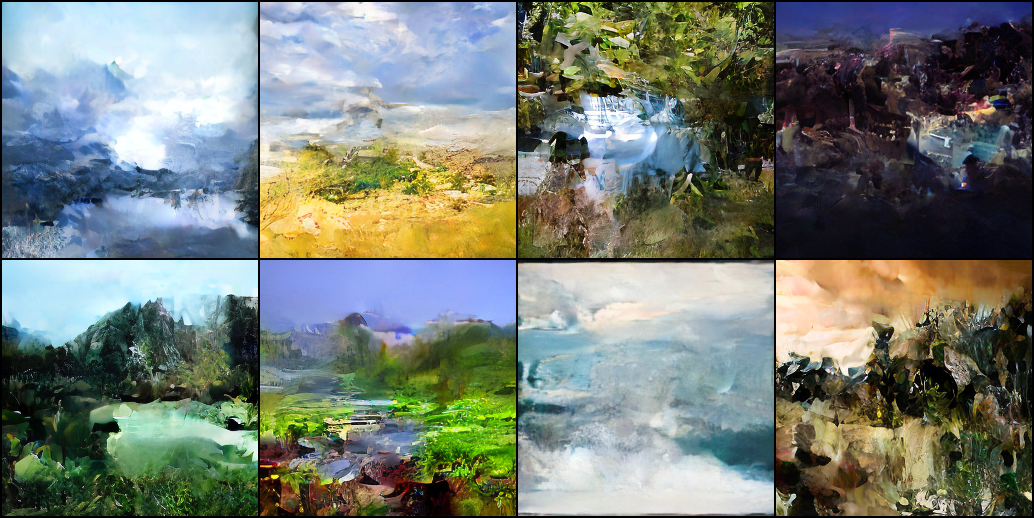

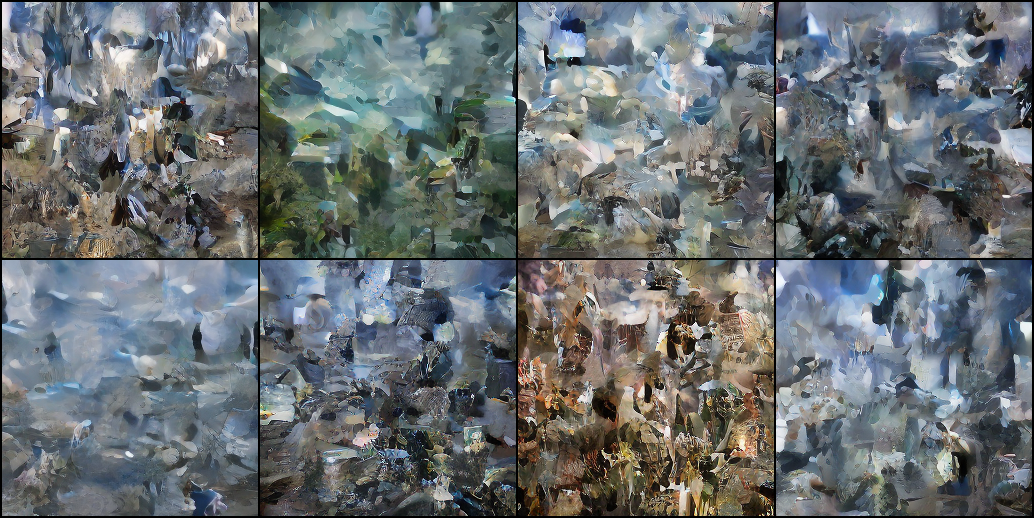

In [22]:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from PIL import Image
from diffusers.models import AutoencoderKL
from models import DiT_B_4 

def load_model_with_key_conversion(model, checkpoint_path, device):
   
    state_dict = torch.load(checkpoint_path, map_location=device)
    new_state_dict = {}
    model_state_dict = model.state_dict()
    
    for key in model_state_dict.keys():
        if 'attn.proj' in key:
            old_key = key.replace('attn.proj', 'attn.out_proj')
            if old_key in state_dict:
                new_state_dict[key] = state_dict[old_key]
            elif key in state_dict:
                new_state_dict[key] = state_dict[key]
            else:
                new_state_dict[key] = model_state_dict[key]
        elif 'attn.qkv.bias' in key and key not in state_dict:
            new_state_dict[key] = model_state_dict[key]
        else:
            new_state_dict[key] = state_dict.get(key, model_state_dict[key])
    
    model.load_state_dict(new_state_dict, strict=False)
    return model

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 256
latent_size = image_size // 8

# Load models
def load_dit_model(checkpoint_path):
    model = DiT_B_4(
        input_size=latent_size,
        num_classes=0,
        learn_sigma=False
    ).to(device)
    model = load_model_with_key_conversion(model, checkpoint_path, device)
    model.eval()
    return model

# Load both models
model_full = load_dit_model("/kaggle/input/hiihihihih/model_full-u.pt")
model_swa = load_dit_model("/kaggle/input/hiihihihih/model_swa-uu.pt")



# Sampling function
def generate_samples(model, vae, n=8, save_path="samples.png"):
    diffusion = create_diffusion("250")
    z = torch.randn(n, 4, latent_size, latent_size, device=device)
    dummy_y = torch.zeros(n, dtype=torch.long, device=device)
    
    # Wrapper function
    def model_forward_wrapper(model):
        def wrapped(x, t, y):
            pred = model(x, t, y)
            return torch.cat([pred, torch.zeros_like(pred)], dim=1)
        return wrapped
    
    # Generate latent
    samples_latent = diffusion.p_sample_loop(
        model_forward_wrapper(model),
        z.shape,
        noise=z,
        clip_denoised=False,
        model_kwargs={"y": dummy_y},
        progress=True,
        device=device
    )
    
    # Decode and save
    with torch.no_grad():
        samples = vae.decode(samples_latent / 0.18215).sample
    
    save_image(samples, save_path, nrow=4, normalize=True, value_range=(-1, 1))
    print(f"Saved samples to {save_path}")
    return samples

# Generate samples from both models
print("Generating full model samples...")
generate_samples(model_full, vae, n=8, save_path="sample_full.png")

print("\nGenerating SWA model samples...")
generate_samples(model_swa, vae, n=8, save_path="sample_swa.png")

# Display results
display(Image.open("sample_full.png"))
display(Image.open("sample_swa.png"))

In [5]:
!pip install -q torch-fidelity

In [9]:


from diffusers import AutoencoderKL
# Import the DiT model
from models import DiT_B_4  
from transformers import CLIPModel, CLIPProcessor
from transformers import AutoModel, AutoProcessor

SiglipModel = AutoModel
SiglipProcessor = AutoProcessor
AlignModel = AutoModel
AlignProcessor = AutoProcessor


def get_clip_embeddings(images, model, processor, device):
    """Extract CLIP image embeddings"""
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    # Normalize embeddings
    embeddings = outputs / outputs.norm(dim=1, keepdim=True)
    return embeddings

def get_siglip_embeddings(images, model, processor, device):
    """Extract SigLIP image embeddings"""
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    # Normalize embeddings
    embeddings = outputs / outputs.norm(dim=1, keepdim=True)
    return embeddings

def get_align_embeddings(images, model, processor, device):
    """Extract ALIGN image embeddings"""
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    # Normalize embeddings
    embeddings = outputs / outputs.norm(dim=1, keepdim=True)
    return embeddings


def mmd_score(real_embeddings, gen_embeddings):
    """
    Calculate the Maximum Mean Discrepancy (MMD) between real and generated image embeddings
    """
    # Move to CPU for calculation to save GPU memory
    real_embeddings = real_embeddings.cpu()
    gen_embeddings = gen_embeddings.cpu()
    
    # Calculate the MMD score
    real_real = torch.mm(real_embeddings, real_embeddings.t())
    real_gen = torch.mm(real_embeddings, gen_embeddings.t())
    gen_gen = torch.mm(gen_embeddings, gen_embeddings.t())
    
    # Calculate mean similarities
    real_real_mean = real_real.mean()
    real_gen_mean = real_gen.mean()
    gen_gen_mean = gen_gen.mean()
    
    # Calculate MMD
    mmd = real_real_mean - 2 * real_gen_mean + gen_gen_mean
    
    return mmd


class SingleClassImageDataset(Dataset):
    """
    A dataset for loading images from a single class folder
    """
    def __init__(self, root_dir, transform=None):
        from PIL import Image
        import os
        
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all image files
        valid_extensions = ['.jpg', '.jpeg', '.png']
        self.image_files = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir)
            if os.path.isfile(os.path.join(root_dir, f)) and 
            os.path.splitext(f)[1].lower() in valid_extensions
        ]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        from PIL import Image
        
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and dummy label (0)
        return image, 0

def load_model_with_key_conversion(model, checkpoint_path, device):
    """
    Load a model state dict with key name conversion to handle mismatched parameter names.
    
    Args:
        model: The model to load weights into
        checkpoint_path: Path to the checkpoint file
        device: Device to load the state dict from
    
    Returns:
        Loaded model
    """
    # Load state dict with map_location to control memory usage
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Create a new state dict with the correct keys
    new_state_dict = {}
    
    # Get the model's own state dict to identify what keys we need
    model_state_dict = model.state_dict()
    
    # Handle key conversions and missing keys
    for key in model_state_dict.keys():
        # For keys that need conversion
        if 'attn.proj' in key:
            old_key = key.replace('attn.proj', 'attn.out_proj')
            if old_key in state_dict:
                new_state_dict[key] = state_dict[old_key]
            elif key in state_dict:
                new_state_dict[key] = state_dict[key]
            else:
                print(f"Warning: Neither {key} nor {old_key} found in checkpoint")
                # Initialize with the model's current parameter
                new_state_dict[key] = model_state_dict[key]
        # For qkv bias keys that might be missing
        elif 'attn.qkv.bias' in key and key not in state_dict:
            print(f"Warning: Missing key {key} in checkpoint, initializing from model")
            # Initialize with the model's current parameter
            new_state_dict[key] = model_state_dict[key]
        # For all other keys
        else:
            if key in state_dict:
                new_state_dict[key] = state_dict[key]
            else:
                print(f"Warning: Key {key} not found in checkpoint, initializing from model")
                new_state_dict[key] = model_state_dict[key]
    
    # Load the modified state dict with strict=False to allow for missing keys
    model.load_state_dict(new_state_dict, strict=False)
    
    # Report how many parameters were successfully loaded
    total_params = len(model_state_dict)
    loaded_params = sum(1 for k in new_state_dict if torch.equal(new_state_dict[k], model_state_dict[k]))
    print(f"Successfully loaded {loaded_params}/{total_params} parameters")
    
    return model

def generate_samples(model, vae, diffusion, num_samples=8, image_size=256, device="cuda", batch_size=8):
    """
    Generate samples from the model in smaller batches to save memory
    """
    latent_size = image_size // 8
    samples_list = []
    
    # Generate in smaller batches
    for i in range(0, num_samples, batch_size):
        curr_batch_size = min(batch_size, num_samples - i)
        print(f"Generating batch {i//batch_size + 1}/{(num_samples + batch_size - 1)//batch_size}...")
        
        # Helper to wrap the model's forward call
        def model_forward_wrapper(model):
            def wrapped(x, t, y):
                pred = model(x, t, y)
                zeros = torch.zeros_like(pred)
                return torch.cat([pred, zeros], dim=1)
            return wrapped
        
        # Initialize random noise
        z = torch.randn(curr_batch_size, 4, latent_size, latent_size, device=device)
        
        # For unconditional generation
        dummy_y = torch.zeros(curr_batch_size, dtype=torch.long, device=device)
        model_kwargs = {"y": dummy_y}
        
        # Generate samples in latent space
        samples_latent = diffusion.p_sample_loop(
            model_forward_wrapper(model),
            shape=z.shape,
            noise=z,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            progress=True,
            device=device
        )
        
        # Decode latents to images in smaller batches if needed
        with torch.no_grad():
            samples = vae.decode(samples_latent / 0.18215).sample
            samples_list.append(samples.cpu())  # Move to CPU immediately
        
        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()
    
    # Concatenate all batches
    return torch.cat(samples_list, dim=0).to(device)

def calculate_cmmd(real_images, generated_images, model_name="clip", batch_size=4, device="cuda"):
    """
    Calculate CLIP/SigLIP/ALIGN Mean Maximum Discrepancy (CMMD) with reduced batch size
    """
    # Load the appropriate model and processor
    if model_name == "clip":
        model, processor = CLIPModel.from_pretrained("openai/clip-vit-base-patch32"), CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    elif model_name == "siglip":
        model, processor = SiglipModel.from_pretrained("google/siglip-base-patch16-224"), SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")
    elif model_name == "align":
        model, processor = AlignModel.from_pretrained("kakaobrain/align-base"), AlignProcessor.from_pretrained("kakaobrain/align-base")
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    model = model.to(device)
    model.eval()
    
    # Convert tensor images to PIL
    if isinstance(real_images, torch.Tensor):
        real_images = [transforms.ToPILImage()(img) for img in real_images]
    if isinstance(generated_images, torch.Tensor):
        generated_images = [transforms.ToPILImage()(img) for img in generated_images]
    
    # Extract embeddings in batches
    real_embeddings = []
    gen_embeddings = []
    
    # Process real images
    for i in range(0, len(real_images), batch_size):
        batch = real_images[i:i+batch_size]
        if model_name == "clip":
            emb = get_clip_embeddings(batch, model, processor, device)
        elif model_name == "siglip":
            emb = get_siglip_embeddings(batch, model, processor, device)
        elif model_name == "align":
            emb = get_align_embeddings(batch, model, processor, device)
        real_embeddings.append(emb.cpu())  # Move to CPU immediately
        torch.cuda.empty_cache()  # Clear cache after each batch
    
    # Process generated images
    for i in range(0, len(generated_images), batch_size):
        batch = generated_images[i:i+batch_size]
        if model_name == "clip":
            emb = get_clip_embeddings(batch, model, processor, device)
        elif model_name == "siglip":
            emb = get_siglip_embeddings(batch, model, processor, device)
        elif model_name == "align":
            emb = get_align_embeddings(batch, model, processor, device)
        gen_embeddings.append(emb.cpu())  # Move to CPU immediately
        torch.cuda.empty_cache()  # Clear cache after each batch
    
    # Concatenate all embeddings (on CPU to save CUDA memory)
    real_embeddings = torch.cat(real_embeddings, dim=0)
    gen_embeddings = torch.cat(gen_embeddings, dim=0)
    
    # Calculate MMD score
    cmmd = mmd_score(real_embeddings, gen_embeddings)
    
    # Clean up to free memory
    del model, processor
    torch.cuda.empty_cache()
    
    return cmmd.item()

def evaluate_models(data_dir, model_full_path, model_swa_path, num_samples=32, image_size=256, device="cuda"):
    """
    Evaluate both models using FID and CMMD (with CLIP, SigLIP, and ALIGN)
    with memory optimization
    """
    # Load DiT models one at a time to save memory
    print("Loading full attention model...")
    model_full = DiT_B_4(input_size=image_size//8, num_classes=0, learn_sigma=False).to(device)
    model_full = load_model_with_key_conversion(model_full, model_full_path, device)
    model_full.eval()
    
    # Load VAE
    print("Loading VAE...")
    vae_model_name = "stabilityai/sd-vae-ft-ema"
    vae = AutoencoderKL.from_pretrained(vae_model_name).to(device)
    vae.eval()
    
    # Create diffusion
    from diffusion import create_diffusion
    diffusion = create_diffusion(str(250))  # Using 250 sampling steps
    
    # Generate samples from the full model
    print("Generating samples from full attention model...")
    samples_full = generate_samples(model_full, vae, diffusion, num_samples=num_samples, device=device, batch_size=4)
    samples_full_norm = (samples_full * 0.5 + 0.5).clamp(0, 1)
    
    # Free memory before loading the next model
    del model_full
    torch.cuda.empty_cache()
    
    # Load the SWA model
    print("Loading SWA model...")
    model_swa = DiT_B_4(input_size=image_size//8, num_classes=0, learn_sigma=False).to(device)
    model_swa = load_model_with_key_conversion(model_swa, model_swa_path, device)
    model_swa.eval()
    
    # Generate samples from the SWA model
    print("Generating samples from SWA model...")
    samples_swa = generate_samples(model_swa, vae, diffusion, num_samples=num_samples, device=device, batch_size=4)
    samples_swa_norm = (samples_swa * 0.5 + 0.5).clamp(0, 1)
    
    # Free model memory
    del model_swa
    torch.cuda.empty_cache()
    
    # Load real images
    print("Loading real images...")
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = SingleClassImageDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Get a sample of real images
    real_images = []
    for images, _ in dataloader:
        real_images.append(images.cpu())  # Store on CPU
        if len(real_images) * images.size(0) >= num_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_samples].to(device)
    real_images_norm = (real_images * 0.5 + 0.5).clamp(0, 1)
    
    # Convert normalized tensors to PIL images for embedding extraction
    print("Converting to PIL images...")
    to_pil = transforms.ToPILImage()
    real_pil = [to_pil(img.cpu()) for img in real_images_norm]
    full_pil = [to_pil(img.cpu()) for img in samples_full_norm]
    swa_pil = [to_pil(img.cpu()) for img in samples_swa_norm]
    
    # Release tensors to free memory
    del real_images
    torch.cuda.empty_cache()
    
    # Calculate FID scores (one model at a time)
    print("Calculating FID scores...")
    from torch_fidelity import calculate_metrics
    
    # Create a dataset for FID calculation
    class Uint8TensorImageDataset(Dataset):
        def __init__(self, images):
            self.images = images
        def __len__(self):
            return self.images.size(0)
        def __getitem__(self, idx):
            img = self.images[idx]
            return (img * 255).clamp(0, 255).to(torch.uint8)
    
    real_dataset = Uint8TensorImageDataset(real_images_norm.cpu())
    
    # Calculate FID for full model
    print("Calculating FID for full model...")
    gen_full_dataset = Uint8TensorImageDataset(samples_full_norm.cpu())
    metrics_full = calculate_metrics(
        input1=real_dataset,
        input2=gen_full_dataset,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=False
    )
    fid_full = metrics_full.get("frechet_inception_distance", "N/A")
    
    # Free memory
    del gen_full_dataset, samples_full_norm
    torch.cuda.empty_cache()
    
    # Calculate FID for SWA model
    print("Calculating FID for SWA model...")
    gen_swa_dataset = Uint8TensorImageDataset(samples_swa_norm.cpu())
    metrics_swa = calculate_metrics(
        input1=real_dataset,
        input2=gen_swa_dataset,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=False
    )
    fid_swa = metrics_swa.get("frechet_inception_distance", "N/A")
    
    # Free memory
    del gen_swa_dataset, samples_swa_norm, real_images_norm, real_dataset
    torch.cuda.empty_cache()
    
    # Calculate CMMD scores with different models (one at a time)
    models = ["clip", "siglip", "align"]
    cmmd_scores = {}
    
    for model_name in models:
        print(f"Calculating {model_name.upper()} MMD scores...")
        try:
            # Calculate for full model
            print(f"  Processing full model with {model_name}...")
            cmmd_full = calculate_cmmd(real_pil, full_pil, model_name=model_name, device=device, batch_size=4)
            
            # Calculate for SWA model
            print(f"  Processing SWA model with {model_name}...")
            cmmd_swa = calculate_cmmd(real_pil, swa_pil, model_name=model_name, device=device, batch_size=4)
            
            cmmd_scores[model_name] = {
                "full": cmmd_full,
                "swa": cmmd_swa
            }
        except Exception as e:
            print(f"Error calculating {model_name.upper()} MMD: {str(e)}")
            cmmd_scores[model_name] = {
                "full": "Error",
                "swa": "Error"
            }
        
        # Clear cache between models
        torch.cuda.empty_cache()
    
    # Print results
    print("\n===== Evaluation Results =====")
    print(f"FID (Full Attention): {fid_full}")
    print(f"FID (SWA): {fid_swa}")
    
    for model_name, scores in cmmd_scores.items():
        print(f"\n{model_name.upper()} MMD:")
        print(f"  Full Attention: {scores['full']}")
        print(f"  SWA: {scores['swa']}")
    
    # Return results (without sample tensors to save memory)
    return {
        "fid": {"full": fid_full, "swa": fid_swa},
        "cmmd": cmmd_scores
    }

if __name__ == "__main__":
    # Set parameters
    data_dir = "/kaggle/input/landscape-pictures"
    model_full_path = "/kaggle/input/hiihihihih/model_full-u.pt"
    model_swa_path = "/kaggle/input/hiihihihih/model_swa-uu.pt"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Set environment variable to help with memory fragmentation
    import os
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    
    # Run evaluation with reduced sample count
    results = evaluate_models(
        data_dir=data_dir,
        model_full_path=model_full_path,
        model_swa_path=model_swa_path,
        num_samples=32,  # Reduced from 64 to save memory
        device=device
    )
    
    # Save results to file
    import json
    
    with open("evaluation_results.json", "w") as f:
        json.dump(results, f, indent=4)
    
    print("\nResults saved to evaluation_results.json")

Loading full attention model...
Successfully loaded 132/132 parameters
Loading VAE...
Generating samples from full attention model...
Generating batch 1/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 2/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 3/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 4/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 5/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 6/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 7/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 8/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Loading SWA model...
Successfully loaded 132/132 parameters
Generating samples from SWA model...
Generating batch 1/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 2/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 3/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 4/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 5/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 6/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 7/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Generating batch 8/8...


  0%|          | 0/250 [00:00<?, ?it/s]

Loading real images...
Converting to PIL images...
Calculating FID scores...
Calculating FID for full model...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Processing samples                                                       
Extracting statistics from input 2
Processing samples                                                       
Frechet Inception Distance: 246.8992661676288
Creating feature extractor "inception-v3-compat" with features ['2048']


Calculating FID for SWA model...


Extracting statistics from input 1
Processing samples                                                       
Extracting statistics from input 2
Processing samples                                                       
Frechet Inception Distance: 388.87852498561443


Calculating CLIP MMD scores...
  Processing full model with clip...
  Processing SWA model with clip...
Calculating SIGLIP MMD scores...
  Processing full model with siglip...
  Processing SWA model with siglip...
Calculating ALIGN MMD scores...
  Processing full model with align...
  Processing SWA model with align...

===== Evaluation Results =====
FID (Full Attention): 246.8992661676288
FID (SWA): 388.87852498561443

CLIP MMD:
  Full Attention: 0.2812194228172302
  SWA: 0.44345635175704956

SIGLIP MMD:
  Full Attention: 0.25273597240448
  SWA: 0.3985597491264343

ALIGN MMD:
  Full Attention: 0.33260107040405273
  SWA: 0.47345298528671265

Results saved to evaluation_results.json


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
from torchvision.utils import make_grid
import os

def visualize_results(results, output_dir="./results"):
    """
    Visualize the evaluation results and sample images
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot FID scores
    plt.figure(figsize=(8, 5))
    models = ["Full Attention", "SWA"]
    fid_scores = [results["fid"]["full"], results["fid"]["swa"]]
    
    plt.bar(models, fid_scores)
    plt.title("FID Scores (Lower is Better)")
    plt.ylabel("FID")
    plt.savefig(os.path.join(output_dir, "fid_comparison.png"))
    plt.close()
    
    # Plot CMMD scores for each embedding model
    plt.figure(figsize=(12, 8))
    
    embedding_models = list(results["cmmd"].keys())
    x = np.arange(len(embedding_models))
    width = 0.35
    
    full_scores = []
    swa_scores = []
    
    for model in embedding_models:
        full_scores.append(results["cmmd"][model]["full"])
        swa_scores.append(results["cmmd"][model]["swa"])
    
    plt.bar(x - width/2, full_scores, width, label="Full Attention")
    plt.bar(x + width/2, swa_scores, width, label="SWA")
    
    plt.title("CMMD Scores by Embedding Model (Lower is Better)")
    plt.ylabel("MMD")
    plt.xlabel("Embedding Model")
    plt.xticks(x, [model.upper() for model in embedding_models])
    plt.legend()
    plt.savefig(os.path.join(output_dir, "cmmd_comparison.png"))
    plt.close()
    
    # Visualize sample images only if they are available
    if (results["samples"]["real"] is not None and 
        results["samples"]["full"] is not None and 
        results["samples"]["swa"] is not None):
        
        # Make a grid of 4x4 images from each set
        grid_real = make_grid(results["samples"]["real"][:16].cpu(), nrow=4)
        grid_full = make_grid(results["samples"]["full"][:16].cpu(), nrow=4)
        grid_swa = make_grid(results["samples"]["swa"][:16].cpu(), nrow=4)
        
        # Plot the grids
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        axs[0].imshow(grid_real.permute(1, 2, 0))
        axs[0].set_title("Real Images")
        axs[0].axis("off")
        
        axs[1].imshow(grid_full.permute(1, 2, 0))
        axs[1].set_title("Full Attention Generated")
        axs[1].axis("off")
        
        axs[2].imshow(grid_swa.permute(1, 2, 0))
        axs[2].set_title("SWA Generated")
        axs[2].axis("off")
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "sample_comparison.png"))
        plt.close()
        print(f"Sample images visualization saved.")
    else:
        print("Sample images not available for visualization.")
    
    print(f"Metrics visualization saved to {output_dir}")

def load_and_visualize(json_path="evaluation_results.json"):
    """
    Load results from JSON and visualize
    """
    with open(json_path, "r") as f:
        results = json.load(f)
    
    # If we don't have sample images in the JSON, we'll create empty placeholders
    if "samples" not in results:
        print("Sample images not found in JSON. Skipping image visualization.")
        results["samples"] = {
            "real": None,
            "full": None,
            "swa": None
        }
    
    visualize_results(results)

if __name__ == "__main__":
    # Check if results are already available
    if os.path.exists("evaluation_results.json"):
        load_and_visualize()
    else:
        print("No evaluation results found. Run the evaluation script first.")

Sample images not found in JSON. Skipping image visualization.
Sample images not available for visualization.
Metrics visualization saved to ./results
